In [16]:
import sys
sys.path.append('../')

In [17]:
from scripts.utils import data_path, set_mpl
from tqdm import tqdm
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import seaborn as sns
from astropy.table import Table 
from astropy.coordinates import SkyCoord
import astropy.io.fits as fits
import healpy as hp
%matplotlib inline

In [18]:
def cat2hpx(lon: np.ndarray, lat: np.ndarray, nside: int, radec: bool = True) -> np.ndarray:
    """
    https://stackoverflow.com/questions/50483279/make-a-2d-histogram-with-healpix-pixellization-using-healpy
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.
    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon (l), glat (b)
    nside : int
        HEALPix nside of the target map
    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.
    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates
    """

    npix = hp.nside2npix(nside)

    if radec:
        eq = SkyCoord(lon, lat, frame="icrs", unit="deg")
        l, b = eq.galactic.l.value, eq.galactic.b.value  # type: ignore
    else:
        l, b = lon, lat

    l, b = np.array(l), np.array(b)
    # conver to theta, phi
    theta = np.radians(90.0 - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)
    # unique because in a pixel there might be lots of sources
    idx, counts = np.unique(indices, return_counts=True)  # type: ignore

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map



# LH X-ray catalog

Read catalog and create a fits table with positions and positional errors

`pos_r98` - radius of a circle which has a probability of finding a counterpart is 98% if it exists, in arcseconds

In [19]:
xcat_orig = pd.read_pickle(data_path+'x-ray/lhpv_03_23_sd01_a15_g14.pkl')

columns_to_retain = ['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_r98'] 

xcat = xcat_orig[xcat_orig['DET_LIKE_0']>6]
xcat = xcat[columns_to_retain]
xcat.rename(columns={'RA_fin':'RA', 'DEC_fin':'DEC', 'pos_r98':'pos_err', 'srcname_fin': 'ID'}, inplace=True)


xcat

,ID,RA,DEC,pos_err
0,SRGe J103744.3+571156,159.434594,57.198788,2.041112
1,SRGe J110137.5+572926,165.406353,57.490464,2.144203
2,SRGe J105825.0+564723,164.604366,56.789762,11.631539
3,SRGe J110537.6+585120,166.406669,58.855424,2.076665
4,SRGe J102349.9+563347,155.958041,56.563186,2.027046
...,...,...,...,...
9495,SRGe J102315.1+561957,155.813071,56.332561,12.277468
9496,SRGe J102332.5+562524,155.885436,56.423270,10.009454
9497,SRGe J102235.0+561919,155.645874,56.321872,9.403089
9498,SRGe J102223.5+562357,155.597875,56.399058,10.245932


In [20]:
xcat.pos_err.describe()

count    9500.000000
mean        8.311198
std         4.529825
min         2.027046
25%         5.779061
50%         7.927672
75%         9.985523
max       145.058319
Name: pos_err, dtype: float64

## area and plotting

In [21]:
xcat_hp_map = cat2hpx(xcat['RA'], xcat['DEC'], nside=1024, radec=True)

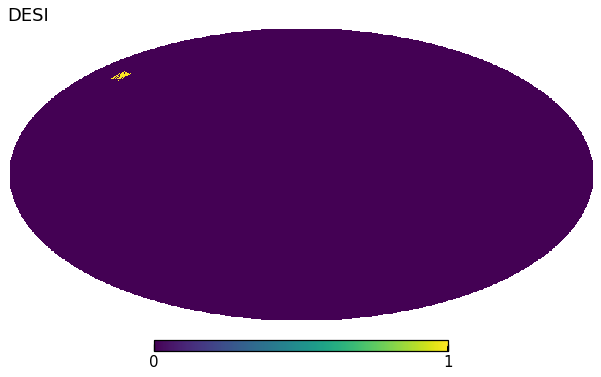

In [22]:
hp.mollview(xcat_hp_map>=1, title='DESI', norm='hist', xsize=800)

18.385776415407125 sq. deg.


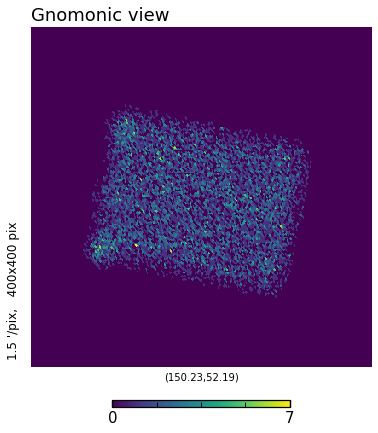

In [23]:
%matplotlib inline
hp.gnomview(xcat_hp_map, rot = [150.23,52.19], xsize = 400)

ERO_SKYAREA = 4*np.pi*(np.rad2deg(1))**2 * np.sum(xcat_hp_map>=1)/len(xcat_hp_map)
print(ERO_SKYAREA, 'sq. deg.')

In [24]:
ero_table = Table.from_pandas(xcat)
ero_table.write(data_path+'x-ray/lhpv_03_23_sd01_a15_g14.fits', overwrite = True)
LH_SKYAREA  = ERO_SKYAREA # sq. deg.
#https://github.com/JohannesBuchner/nway/blob/master/nway-write-header.py
with fits.open(data_path+'x-ray/lhpv_03_23_sd01_a15_g14.fits' , 'update') as file:
    file[1].name = 'eROSITA'
    file[1].header['SKYAREA'] = LH_SKYAREA
    file.flush()

# LH DESI catalog

All DESI objects within LH area + a little boundary


In [25]:
pd.read_pickle(data_path+'multi-wave/desi_lh.pkl').head(1)

,release,objid,brickid,ra,dec,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,dered_mag_w3,dered_mag_w4
0,9011,2962,623750,161.786078,62.311214,0.206368,0.235311,0.22482,0.573512,1.127776,7.362708,22.38832,785.7445,312.1193,113.888916,4.83957,1.178214,0.001385,0.000017,24.182678,24.050201,24.108839,23.101885,22.368362,20.332176,19.124859


In [71]:
desi_cat_orig = pd.read_pickle(data_path+'multi-wave/desi_lh.pkl')
desi_cat_orig.head(5)

desi_cat_orig['desi_id'] = desi_cat_orig.apply(lambda row: str(row['brickid'])+'_'+str(row['objid']), axis=1)

columns_to_retain = ['desi_id', 'ra', 'dec', 'dered_mag_g', 'dered_mag_r', 'dered_mag_z', 'dered_mag_w1', 'dered_mag_w2', 'dered_mag_w3', 'dered_mag_w4' ] 
desi_cat_orig = desi_cat_orig[columns_to_retain]

#desi_cat_orig.rename(columns={'RA_fin':'ero_RA', 'DEC_fin':'ero_DEC', 'srcname_fin': 'ero_id', 'ra': 'RA', 'dec': 'DEC'}, inplace=True)

desi_cat_orig.reset_index(inplace=True, drop = True)
desi_cat_orig.head(5)

,desi_id,ra,dec,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,dered_mag_w3,dered_mag_w4
0,623750.0_2962.0,161.786078,62.311214,24.182678,24.050201,24.108839,23.101885,22.368362,20.332176,19.124859
1,623750.0_2964.0,161.786175,62.308431,22.601620,22.089499,22.046227,21.308537,20.618176,18.079147,17.040676
2,623750.0_3023.0,161.795663,62.309075,23.855670,22.821260,22.572979,NaN,22.684746,20.280249,NaN
3,623750.0_2993.0,161.789851,62.306325,22.668740,21.989480,21.126097,19.418169,19.502636,NaN,16.332191
4,623750.0_3026.0,161.796264,62.305792,23.913218,23.265640,23.273476,NaN,NaN,NaN,16.668236


## area and plotting

In [72]:
desi_hp_map = cat2hpx(desi_cat_orig['ra'], desi_cat_orig['dec'], nside=1024, radec=True)

In [73]:
np.rad2deg(hp.nside2resol(1024))

0.05725810686362343

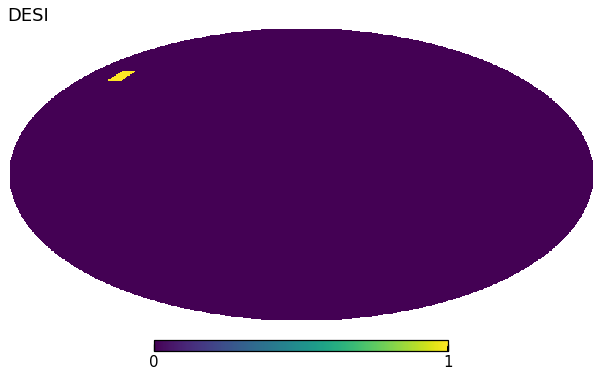

In [74]:
hp.mollview(desi_hp_map>=1, title='DESI', norm='hist', xsize=800)

41.728630922842704 sq. deg.


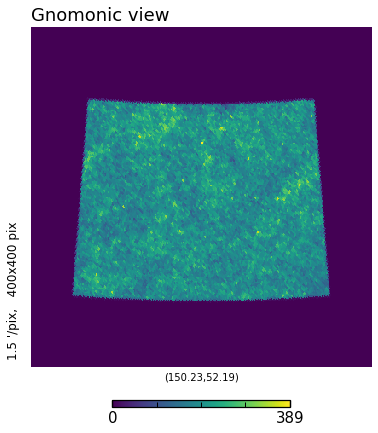

In [75]:
%matplotlib inline
hp.gnomview(desi_hp_map, rot = [150.23,52.19], xsize = 400)

DESI_SKYAREA = 4*np.pi*(np.rad2deg(1))**2 * np.sum(desi_hp_map>=1)/len(desi_hp_map)
print(DESI_AREA, 'sq. deg.')

In [77]:
desi_table = Table.from_pandas(desi_cat_orig)
desi_table.write(data_path+'multi-wave/desi_lh.fits', overwrite = True)

with fits.open(data_path+'multi-wave/desi_lh.fits' , 'update') as file:
    file[1].name = 'DESI'
    file[1].header['SKYAREA'] = DESI_SKYAREA
    file.flush()